<a href="https://colab.research.google.com/github/CallingKEB/AIFFEL_quest_cr/blob/main/MainQuest/Quest03/MainQuest03_2024_09_30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 폐렴아 기다려라!(Main_Quest_CR9), 2024-09-30
 - 목표: 폐렴(Pneumonia)을 찾아내는 딥러닝 모델을 만드는 것   
 - 데이터셋: 캐글의 Chest X-Ray Images
    - 구성: ~/aiffel/chest_xray/data 하위에 3개의 폴더 (train, test, val), (폐렴 / 정상)에 대한 하위 폴더를 포함
    -  5,856 개의 X-Ray 이미지 (JPEG)와 2 개의 범주 (폐렴 / 정상)
    - 전체 데이터의 크기는 총 1.2GB 가량
    - 출처: 중국 광저우 여성 및 어린이 병원의 1~5 세 소아 환자의 흉부 X선 영상
    - 참고: (에디터 주) 캐글에서 다운로드한 데이터는 chest_xray 하위에 chest_xray 폴더가 중복으로 포함되어 있어서 전체 데이터의 크기가 2.5GB인 경우가 있으나, 중복된 데이터는 필요하지 않음



### [목차]
1. Set-up
2. 데이터 가져오기
3. 데이터 시각화
4. CNN 모델링
5. 데이터 imbalance 처리
6. 모델 훈련
7. 결과 확인



## 1. Set- up
- 패키지(라이브러리)들 import
- 변수들을 생성

- Tip
    - CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘함  
    - test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제없음


In [ ]:
# 패키지 목록
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
# 변수 생성
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수 (chest_xray 밑에 train, val, text 폴더로 구성)
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


## 2. 데이터 가져오기
-  train, val(validation), test 로 나누어져 있음

In [ ]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))     # 5216개 (89%)
print(len(test_filenames))      # 624개 (10.7%)
print(len(val_filenames))       # 16개 (0.3%)

5216
624
16


In [ ]:
# val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져와
# train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))     # 4185개
print(len(val_filenames))       # 1047개

4185
1047


In [ ]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/train/NORMAL/IM-0404-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/train/PNEUMONIA/person614_virus_1183.jpeg


In [ ]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [ ]:
# tf.data 인스턴스는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 함

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [ ]:
# Train 데이터셋, validation 데이터셋 개수 확인

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [ ]:
# 파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에
# 라벨 데이터를 만들어 주는 함수 생성

# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   #폐렴이면 양성(True), 노말이면 음성(False)

In [ ]:
# 이미지 사이즈 줄이기(사이즈 통일 및 GPU 메모리 고려)
# >> decode_img 함수와 process_path 함수 생성

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [ ]:
# train 데이터 셋과 validation 데이터 셋 만들고
#  num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
# 이미지가 잘 리사이즈 되었는지,
# 라벨이 잘 들어가 있는지 확인

for image, label in train_ds.take(1):           # 하나의 데이터만 가져올 때
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [ ]:
# test 데이터셋 만들고, 데이터 개수 확인

test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)     # 624

624


'''
 tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환
 shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
 repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있음
 batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어짐
 prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있음
'''

In [ ]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 3. 데이터 시각화
-  데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출
- 추출된 배치를 image와 label 데이터 셋으로 나눔
- show_batch() 함수를 이용해서 결과 사진을 확인

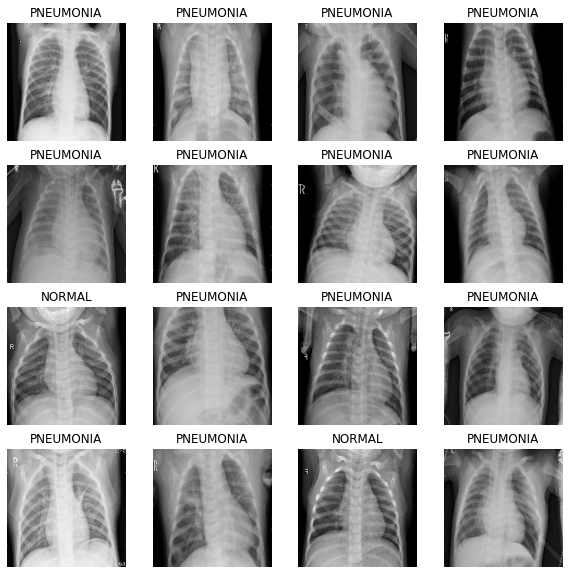

In [ ]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 4. CNN 모델링
-  Convolution block을 만들고 Max Pooling 진행  
    - conv_block()의 구성:
        - Convolution을 두 번 진행
        - Batch Normalization을 통해 Gradient vanishing, Gradient Exploding을 해결

-  참고: CNN(Convolutional Neural Network) 요약 블로그 http://taewan.kim/post/cnn/

In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])

    return block

In [ ]:
# Dense Block 만들기

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

In [ ]:
# 2가지 regularization 기법 동시에 사용시 성능 향상 여부 확인
# Batch Normalization과 Dropout

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

## 5. 데이터 imbalance 처리
- imbalance: 한 라벨이 너무 많은 경우 ->> 데이터 학습 시 효과가 좋지 않을 수 있음
    - 솔루션: Weight balancing이라는 테크닉 사용
        - training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여
        - Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원

In [ ]:
# weight_for_0은 'Normal' 이미지에 사용할 weight를
# weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅
# weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


## 6. 모델 훈련
- GPI 선택(이미지 훈련이므로)
-  build_model()을 model에 선언
- 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용
- optimizer로 'adam'을 사용
- metrics으로 'accuracy', 'precision', 'recall'을 사용


In [ ]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 88s 284ms/step - loss: 0.5003 - accuracy: 0.7692 - precision: 0.9340 - recall: 0.7423 - val_loss: 0.5931 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 54s 208ms/step - loss: 0.3112 - accuracy: 0.8755 - precision: 0.9627 - recall: 0.8659 - val_loss: 0.6286 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 54s 209ms/step - loss: 0.2594 - accuracy: 0.8932 - precision: 0.9631 - recall: 0.8906 - val_loss: 0.4051 - val_accuracy: 0.8394 - val_precision: 0.9967 - val_recall: 0.7837
Epoch 4/10
261/261 [==============================] - 55s 212ms/step - loss: 0.2082 - accuracy: 0.9191 - precision: 0.9746 - recall: 0.9149 - val_loss: 0.5127 - val_accuracy: 0.8317 - val_precision: 0.9983 - val_recall: 0.7723
Epoch 5/10
261/261 [==============================] - 56s 217ms/step - loss: 0.1968 - accura

## 7. 결과 확인

- Tip:
    - 의료 데이터의 경우 구하기도 어렵고 구하더라도 데이터가 작은 경우가 많음 -> Data augmentation 방법을 많이 시도
    - Data augmentation 은 각 데이터에 최적화된 방법을 찾기가 어렵고 제약사항이 많아, 기본적인 Data augmentation 방법인 "이미지 회전, 가우시안 노이즈 추가 방법 등"을 많이 사용
    - 특히 장기의 크기는 사람마다 거의 바뀌지 않으므로, 이런 특성을 이용한 방법이 노이즈 추가 방법임
    - 전통적인 Data augmentation 방법 이외에도 GAN을 이용해서 Data augmentation을 시도하는 연구도 있음

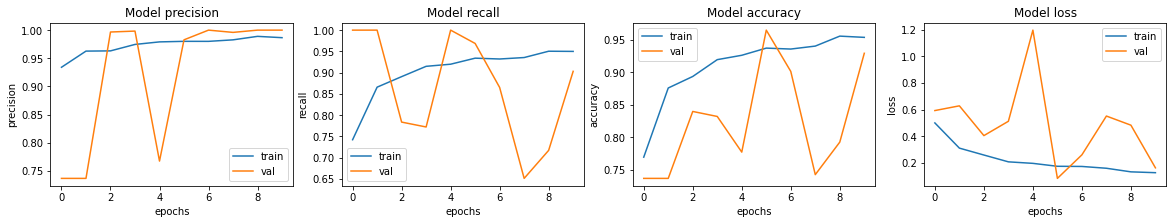

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 119ms/step - loss: 0.2642 - accuracy: 0.8990 - precision: 0.9017 - recall: 0.9410
Loss: 0.2642062306404114,
Accuracy: 0.8990384340286255,
Precision: 0.9017199277877808,
Recall: 0.9410256147384644


## **3-1. 프로젝트: 폐렴 진단기 성능개선**

#### Step 1. 실험환경 Set-up
#### Step 2. 데이터 준비하기
#### Step 3. 데이터 시각화
#### Step 4. ResNet-18 구현
#### Step 5. 데이터 imbalance 처리
#### Step 6. 모델 훈련
#### Step 7. 결과 확인과 시각화


In [ ]:
# 라이브러리 버전 확인
import tensorflow

print(tensorflow.__version__)

2.6.0


In [ ]:
# 모델을 만드는 데에 필요한 모듈 불러오기
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import plot_model # 모델 시각화

### Step 1. 실험환경 Set-up
- Batch size, Epoch 등 변경

In [ ]:
BATCH_SIZE = 32
EPOCHS = 10

### Step 2. 데이터 준비하기
-  좌우 반전 정도의 augmentation만 도입

In [ ]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))     # 5216개 (89%)
print(len(test_filenames))      # 624개 (10.7%)
print(len(val_filenames))       # 16개 (0.3%)

5216
624
16


In [ ]:
# val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져와
# train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))     # 4185개
print(len(val_filenames))       # 1047개

4185
1047


In [ ]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/train/NORMAL/IM-0404-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/train/PNEUMONIA/person614_virus_1183.jpeg


In [ ]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [ ]:
# tf.data 인스턴스는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 함

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [ ]:
# Train 데이터셋, validation 데이터셋 개수 확인

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [ ]:
# 파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에
# 라벨 데이터를 만들어 주는 함수 생성

# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [ ]:
# 이미지 사이즈 줄이기(사이즈 통일 및 GPU 메모리 고려)
# >> decode_img 함수와 process_path 함수 생성

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [ ]:
# train 데이터 셋과 validation 데이터 셋 만들고
#  num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
# 이미지가 잘 리사이즈 되었는지,
# 라벨이 잘 들어가 있는지 확인

for image, label in train_ds.take(1):           # 하나의 데이터만 가져올 때
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [ ]:
# test 데이터셋 만들고, 데이터 개수 확인

test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)     # 624

624


In [ ]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

ValueError: in user code:

    /tmp/ipykernel_1120/823717284.py:2 augment  *
        image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper  **
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/image_ops_impl.py:422 random_flip_left_right
        return _random_flip(image, 1, random_func, 'random_flip_left_right')
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/image_ops_impl.py:537 _random_flip
        raise ValueError(

    ValueError: 'image' (shape (None, None, None, None, 180, 180, 3)) must have either 3 or 4 dimensions.


In [ ]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [ ]:
'''
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)
'''

'\ndef augment(image,label):\n    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.\n    return image,label\n\ndef prepare_for_training(ds, shuffle_buffer_size=1000):\n    # augment 적용 부분이 배치처리 함수에 추가되었습니다.\n    ds = ds.map(\n            augment,       # augment 함수 적용\n            num_parallel_calls=2\n        )\n    ds = ds.shuffle(buffer_size=shuffle_buffer_size)\n    ds = ds.repeat()\n    ds = ds.batch(BATCH_SIZE)\n    ds = ds.prefetch(buffer_size=AUTOTUNE)\n\n    return ds\n\ntrain_ds = prepare_for_training(train_ds)\nval_ds = prepare_for_training(val_ds)\n'

In [ ]:
'''

ValueError: 'image' (shape (None, None, 180, 180, 3)) must have either 3 or 4 dimensions.
해결을 위해 map 함수에서 배치 차원 분리 활용. 이를 위해 tf.map_fn을 사용하여 배치된 이미지를 처리


def augment(image, label):
    image = tf.map_fn(tf.image.random_flip_left_right, image)  # 배치 내의 각 이미지를 좌우 반전
    #image = tf.image.resize(image, [180,180])    # 이미지를 리사이즈

    return image, label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(
        augment,  # augment 함수 적용
        num_parallel_calls=tf.data.AUTOTUNE
    )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # ds = ds.repeat()      # repeat() 에러가 계속 나서 사용 x
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 입력 데이터 형태 확인
for images, labels in train_ds.take(1):
    print(images.shape, labels.shape)  # 출력 예시: (BATCH_SIZE, 180, 180, 3)
'''

### Step 3. 데이터 시각화
-   show_batch() 함수를 통해 실제로 좌우 반전 등이 제대로 처리되었는지 확인

In [ ]:
'''
1. 이전과 같이 실행하면 kernel이 계속 죽어서
실제 배치 크기를 가져오는 걸로 수정
2. TypeError: Invalid shape (16, 180, 180, 3) for image data

# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

# 배치 데이터 시각화
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())
'''

KeyboardInterrupt: 

TypeError: Invalid shape (32, 180, 180, 3) for image data

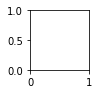

In [ ]:
import matplotlib.pyplot as plt
import math

# 이미지 배치를 입력하면 여러 장의 이미지를 보여주고
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    batch_size = image_batch.shape[0]  # 실제 배치 크기를 가져옴
    for n in range(batch_size):
        ax = plt.subplot(4, math.ceil(batch_size / 4), n + 1)

        # 이미지가 [0,1]정규화 되었으므로 0-255 범위로 변환
        image = image_batch[n] * 255.0
        image = image.astype('uint8')  # uint8로 변환

        plt.imshow(image_batch[n])     # 이미지 시각화
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")
    plt.show()

# 배치 데이터 시각화
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### Step 4. ResNet-18 구현
- ResNet의 특징: Residual Connection으로 학습된 정보가 데이터 처리과정에서 손실되는 것을 방지
- Residual block을 먼저 구성, weight layer 구성
    - 3x3 CNN
    - BatchNormalization
    - 활성화 함수 ReLU
- ResNet을 구현

In [ ]:
# 1. Residual block 구성하기

import tensorflow as tf
from tensorflow.keras import layers, Model

# Residual Block 정의
def residual_block(x, filters, kernel_size=3, stride=1, downsample=False):
    identity = x

    # 첫 번째 3x3 Convolutional Layer + BatchNormalization + ReLU
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 두 번째 Convolutional Layer
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # 입력-출력 차원이 다를때 (downsample = True)
    if downsample or stride != 1:
        identity = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same', use_bias=False)(identity)
        identity = layers.BatchNormalization()(identity)

    # skip connection 추가 (identity + convolution output)
    x = layers.add([x, identity])
    x = layers.ReLU()(x)

    return x

In [ ]:
# 2. ResNet-18 구현

'''
Conv layer + Max pooling layer
Residual Block
Average pooling
Fully Connected layer
'''

# 이미지는 224 x 224로 가정하여 사용 -> 180 x 180로 수정
def resnet18(input_shape=(180, 180, 3), num_classes=2):   # class 수가 1000일 때 오류
    inputs = layers.Input(shape=input_shape)

    # Conv1: 7x7 Convolution + MaxPooling
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Conv2_x: 2 Residual Blocks (64 Filters)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

    # Conv3_x: 2 Residual Blocks (128 Filters)
    x = residual_block(x, filters=128, downsample=True, stride=2)
    x = residual_block(x, filters=128)

    # Conv4_x: 2 Residual Blocks (256 Filters)
    x = residual_block(x, filters=256, downsample=True, stride=2)
    x = residual_block(x, filters=256)

    # Conv5_x: 2 Residual Blocks (512 Filters)
    x = residual_block(x, filters=512, downsample=True, stride=2)
    x = residual_block(x, filters=512)

    # Average Pooling and Dense Layer
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)  # fully connected layer

    # Create Model
    model = tf.keras.Model(inputs, outputs)
    return model

### Step 5. 데이터 imbalance 처리
- 데이터 비율로 나누어진 class_weight를 설정
- recall을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 더 강화하는 효과 시도

In [ ]:
# class_weight를 설정 >> 각 클래스 샘플 수 기준 가중치 계산

# weight_for_0은 'Normal' 이미지에 사용할 weight를
# weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅
# weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


### Step 6. 모델 훈련
- loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려

In [ ]:
from tensorflow.keras.metrics import Recall
with tf.device('/GPU:0'):
    #model = resnet18(input_shape=(180, 180, 3), num_classes=1000)  # num_classes=1000은 ImageNet 기준
    model = resnet18()

    METRICS = ['accuracy',
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=METRICS
    )

In [ ]:
# 모델 구조 확인
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 90, 90, 64)   9408        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 90, 90, 64)   256         conv2d_20[0][0]                  
__________________________________________________________________________________________________
re_lu_17 (ReLU)                 (None, 90, 90, 64)   0           batch_normalization_20[0][0]     
____________________________________________________________________________________________

In [ ]:
'''
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )
'''

In [ ]:
# 데이터셋에서 배치 형태 출력
for images, labels in train_ds.take(1):
    print(images.shape, labels.shape)  # (BATCH_SIZE, 180, 180, 3) 확인

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 데이터셋의 배치 형태 출력
for images, labels in train_ds.take(1):
    print("Images shape:", images.shape)  # (BATCH_SIZE, 180, 180, 3)
    print("Labels shape:", labels.shape)   # (BATCH_SIZE,)

# 모델 컴파일
METRICS = ['accuracy', tf.keras.metrics.Recall(name='recall')]
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=METRICS)

# 모델 훈련
history = model.fit(
    train_ds,
    steps_per_epoch=train_size // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=val_size // BATCH_SIZE,
    class_weight=class_weight,
)

(32, 180, 180, 3) (32,)


In [ ]:
'''
# callback을 활용한 EarlyStopping

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_recall', patience=5, mode='max', restore_best_weights=True)

# 모델 학습 시 callback 적용
model.fit(train_ds,
          epochs=10,
          validation_data=val_ds,
          class_weight=class_weight_dict,
          callbacks=[early_stopping])
'''

### Step 7. 결과 확인과 시각화
- Tip: 모델 학습이 안정적으로 수렴하는 것을 확인
- accuracy를 고려
- recall도 중요
- 훈련과정의 history 그래프를 시각화

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nRecall: {recall}')

## 회고

- 처음 X-ray로 실험할때는 계속 코랩에서 문제였는데(데이터가 조금씩 상이했음), 쥬피터노트북에서는 괜찮았다. 하지만 프로젝트에서는 계속 shape관련하여 Error가 발생하여, 여러방법으로 시도해보았으나, 계속적으로 Dead kernel이 발생했고, 결과를 얻지 못하였다.